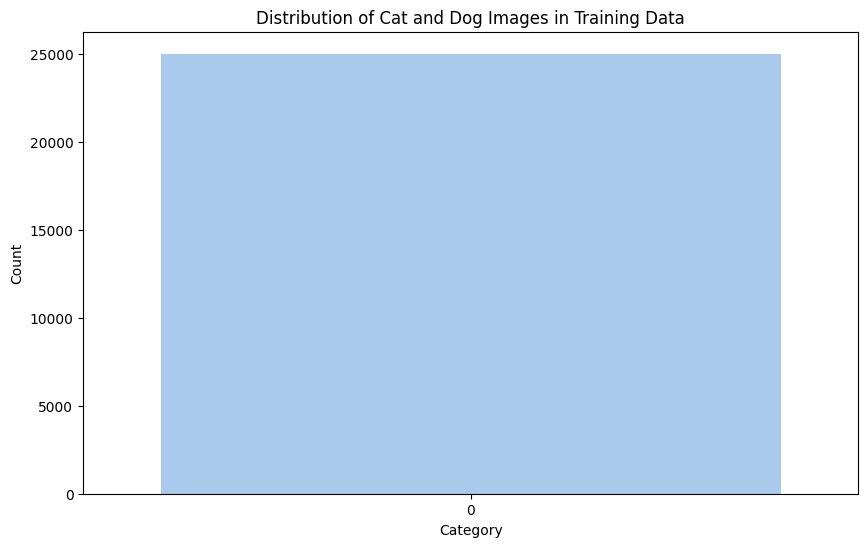

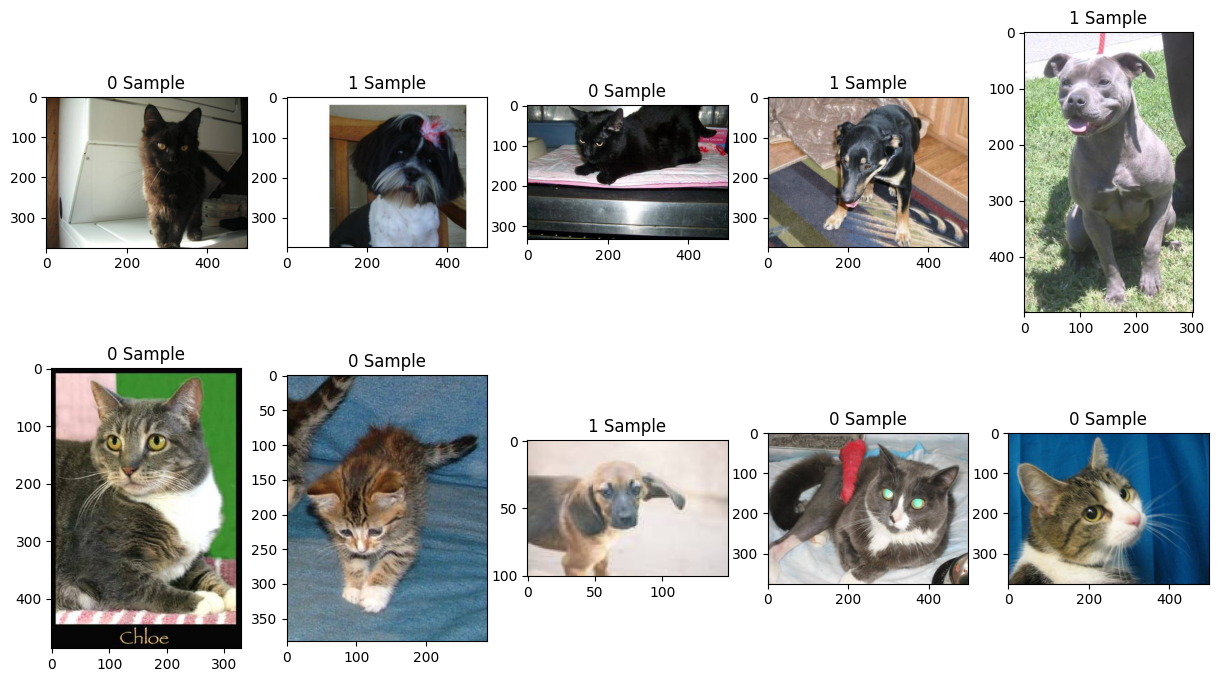

TypeError: ImageDataGenerator.__init__() got an unexpected keyword argument 'shuffle'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import keras
import os
import scikitplot as skplt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to load and process data
def load_and_process_data(train_zip_path, test_zip_path):
    with zipfile.ZipFile(train_zip_path, 'r') as z:
        z.extractall("C:/Users/ishan/Downloads/dogs-vs-cats/train")

    with zipfile.ZipFile(test_zip_path, 'r') as z:
        z.extractall("C:/Users/ishan/Downloads/dogs-vs-cats/test1")

    train_filenames = os.listdir('C:/Users/ishan/Downloads/dogs-vs-cats/train')
    test_filenames = os.listdir('C:/Users/ishan/Downloads/dogs-vs-cats/test1')

    train_categories = [1 if filename.split('.')[0] == 'dog' else 0 for filename in train_filenames]

    train_df = pd.DataFrame({
        'filename': train_filenames,
        'category': train_categories
    })
    train_df['category'] = train_df['category'].astype('str')  # Ensure 'category' is treated as a string

    # Enhanced visualization using seaborn and plotly
    plt.figure(figsize=(10, 6))
    sns.set_palette("pastel")
    sns.countplot(train_df['category'])
    plt.title('Distribution of Cat and Dog Images in Training Data')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()

    return train_df, test_filenames

# Function to visualize image samples
def visualize_samples(train_df, num_samples=10):
    plt.figure(figsize=(15, 8))
    for i, (_, row) in enumerate(train_df.sample(num_samples, random_state=42).iterrows(), 1):
        plt.subplot(2, num_samples // 2, i)
        img = load_img("C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename'])
        plt.imshow(img)
        plt.title(f"{row['category'].capitalize()} Sample")

    plt.show()

# Function to build the model
def build_model():
    model = keras.models.Sequential([
        # ... (your model architecture)
    ])

    model.summary()
    keras.utils.plot_model(model, 'model.png')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to train the model
def train_model(model, train_generator, valid_generator, callbacks, epochs=30):
    total_train = train_generator.n // train_generator.batch_size
    total_validate = valid_generator.n // valid_generator.batch_size

    history = model.fit(train_generator, epochs=epochs, verbose=1, validation_data=valid_generator,
                        validation_steps=total_validate,
                        steps_per_epoch=total_train,
                        callbacks=callbacks)

    return model, history

# Function to visualize training history using plotly
def visualize_results(history):
    fig = make_subplots(rows=2, cols=1, subplot_titles=('Loss', 'Accuracy'))

    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['loss'], mode='lines', name='Training Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['val_loss'], mode='lines', name='Validation Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['accuracy'], mode='lines', name='Training Accuracy'), row=2, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'), row=2, col=1)

    fig.update_layout(title='Training and Validation Metrics Over Epochs',
                      xaxis_title='Epochs',
                      template='plotly_dark')
    fig.show()

# Function to evaluate model and show confusion matrix
def evaluate_model(model, valid_generator, valid_data):
    nb_samples = valid_generator.n
    predict = model.predict(valid_generator, steps=np.ceil(nb_samples/valid_generator.batch_size))

    valid_data['predicted_category'] = np.argmax(predict, axis=-1)
    label_map = dict((v, k) for k, v in train_generator.class_indices.items())
    valid_data['predicted_category'] = valid_data['predicted_category'].replace(label_map)

    # Confusion matrix
    cm = confusion_matrix(valid_data['category'], valid_data['predicted_category'], labels=['cat', 'dog'])

    # Plot confusion matrix
    skplt.metrics.plot_confusion_matrix(valid_data['category'], valid_data['predicted_category'], labels=['cat', 'dog'], cmap='viridis')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(valid_data['category'], valid_data['predicted_category']))

# Function to display random images of dogs and cats
def display_random_images(df, num_images=5, category=None):
    plt.figure(figsize=(15, 8))
    random_samples = df[df['category'] == category].sample(num_images, random_state=42)

    for i, (_, row) in enumerate(random_samples.iterrows(), 1):
        plt.subplot(2, num_images, i)
        img = load_img("C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename'])
        plt.imshow(img)
        plt.title(f"Actual: {row['category']}")

        plt.subplot(2, num_images, i + num_images)
        img_path = "C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename']
        predict_on_new_image(model, img_path)

    plt.show()

# Main part of the code
train_zip_path = "C:/Users/ishan/Downloads/dogs-vs-cats/train.zip"
test_zip_path = "C:/Users/ishan/Downloads/dogs-vs-cats/test1.zip"

train_df, test_filenames = load_and_process_data(train_zip_path, test_zip_path)

visualize_samples(train_df, num_samples=10)

train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shuffle=True
)

valid_data_gen = ImageDataGenerator(rescale=1./255, shuffle=True)

train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    "C:/Users/ishan/Downloads/dogs-vs-cats/train/",
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=15
)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    "C:/Users/ishan/Downloads/dogs-vs-cats/train/",
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=15
)

model = build_model()

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

model, history = train_model(model, train_generator, valid_generator, callbacks, epochs=30)

visualize_results(history)

# Evaluate model and show confusion matrix
evaluate_model(model, valid_generator, valid_data)

# Display random images of cats and dogs
display_random_images(valid_data, num_images=5, category='cat')
display_random_images(valid_data, num_images=5, category='dog')

# Example: Make prediction on a new image
sample_path = "C:/Users/ishan/Downloads/dogs-vs-cats/train/" + train_df['filename'].iloc[60]
predict_on_new_image(model, sample_path)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import keras
import os
import scikitplot as skplt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to load and process data
def load_and_process_data(train_zip_path, test_zip_path):
    with zipfile.ZipFile(train_zip_path, 'r') as z:
        z.extractall("C:/Users/ishan/Downloads/dogs-vs-cats/train")

    with zipfile.ZipFile(test_zip_path, 'r') as z:
        z.extractall("C:/Users/ishan/Downloads/dogs-vs-cats/test1")

    train_filenames = os.listdir('C:/Users/ishan/Downloads/dogs-vs-cats/train')
    test_filenames = os.listdir('C:/Users/ishan/Downloads/dogs-vs-cats/test1')

    train_categories = [1 if filename.split('.')[0] == 'dog' else 0 for filename in train_filenames]

    train_df = pd.DataFrame({
        'filename': train_filenames,
        'category': train_categories
    })
    train_df['category'] = train_df['category'].astype('str')  # Ensure 'category' is treated as a string

    # Enhanced visualization using seaborn and plotly
    plt.figure(figsize=(10, 6))
    sns.set_palette("pastel")
    sns.countplot(train_df['category'])
    plt.title('Distribution of Cat and Dog Images in Training Data')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()

    return train_df, test_filenames

# Function to visualize image samples
def visualize_samples(train_df, num_samples=10):
    plt.figure(figsize=(15, 8))
    for i, (_, row) in enumerate(train_df.sample(num_samples, random_state=42).iterrows(), 1):
        plt.subplot(2, num_samples // 2, i)
        img = load_img("C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename'])
        plt.imshow(img)
        plt.title(f"{row['category'].capitalize()} Sample")

    plt.show()

# Function to build the model
def build_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
    ])

    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Function to train the model
def train_model(model, train_generator, valid_generator, callbacks, epochs=30):
    total_train = train_generator.n // train_generator.batch_size
    total_validate = valid_generator.n // valid_generator.batch_size

    history = model.fit(train_generator, epochs=epochs, verbose=1, validation_data=valid_generator,
                        validation_steps=total_validate,
                        steps_per_epoch=total_train,
                        callbacks=callbacks)

    return model, history

# Function to visualize training history using plotly
def visualize_results(history, epochs):
    fig = make_subplots(rows=2, cols=1, subplot_titles=('Loss', 'Accuracy'))

    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['loss'], mode='lines', name='Training Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['val_loss'], mode='lines', name='Validation Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['accuracy'], mode='lines', name='Training Accuracy'), row=2, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'), row=2, col=1)

    fig.update_layout(title='Training and Validation Metrics Over Epochs',
                      xaxis_title='Epochs',
                      template='plotly_dark')
    fig.show()

# Function to evaluate model and show confusion matrix
def evaluate_model(model, valid_generator, valid_data):
    nb_samples = valid_generator.n
    predict = model.predict(valid_generator, steps=np.ceil(nb_samples/valid_generator.batch_size))

    valid_data['predicted_category'] = np.round(predict).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(valid_data['category'], valid_data['predicted_category'])

    # Plot confusion matrix
    skplt.metrics.plot_confusion_matrix(valid_data['category'], valid_data['predicted_category'], cmap='viridis')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(valid_data['category'], valid_data['predicted_category']))

# Function to display random images of dogs and cats
def display_random_images(df, model, num_images=5, category=None):
    plt.figure(figsize=(15, 8))
    random_samples = df[df['category'] == category].sample(num_images, random_state=42)

    for i, (_, row) in enumerate(random_samples.iterrows(), 1):
        plt.subplot(2, num_images, i)
        img = load_img("C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename'])
        plt.imshow(img)
        plt.title(f"Actual: {row['category']}")

        plt.subplot(2, num_images, i + num_images)
        img_path = "C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename']
        predict_on_new_image(model, img_path)

    plt.show()

# Main part of the code
train_zip_path = "C:/Users/ishan/Downloads/dogs-vs-cats/train.zip"
test_zip_path = "C:/Users/ishan/Downloads/dogs-vs-cats/test1.zip"

train_df, test_filenames = load_and_process_data(train_zip_path, test_zip_path)

visualize_samples(train_df, num_samples=10)

train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

train_data_gen = ImageDataGenerator(
    rotation_range=15


SyntaxError: incomplete input (453251014.py, line 152)

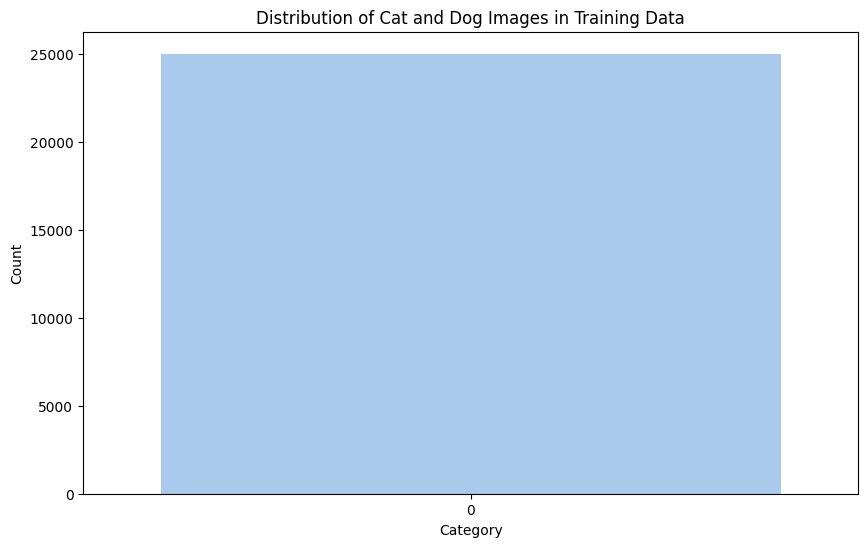

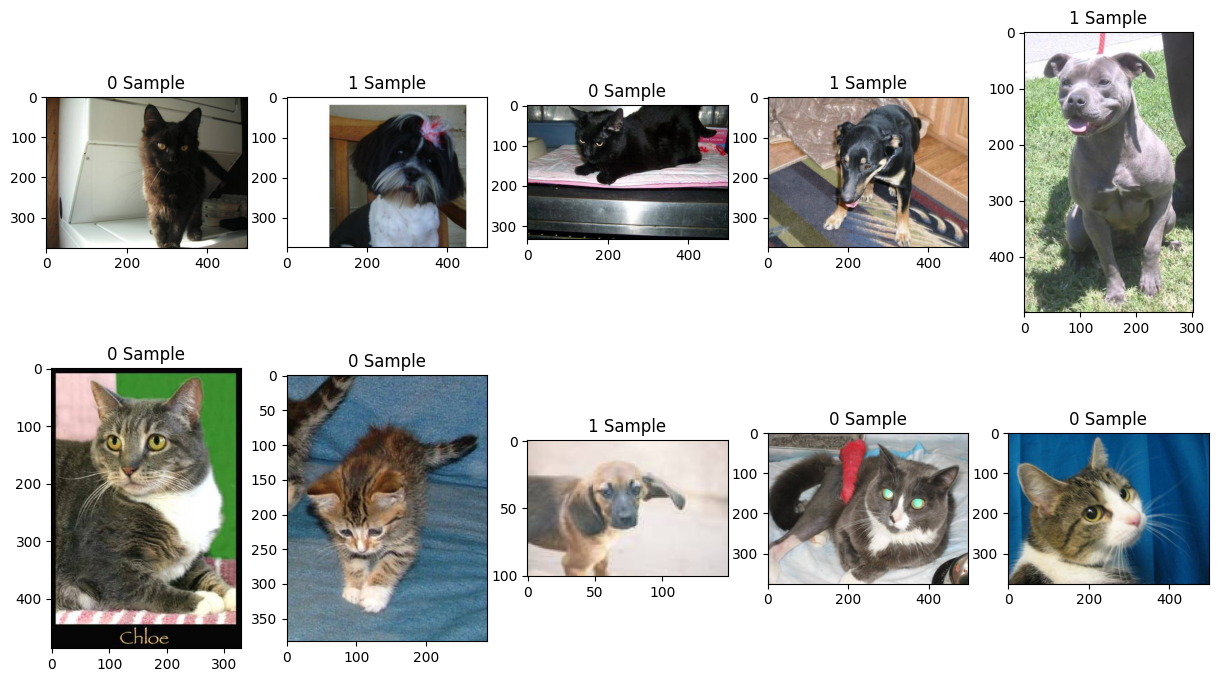

Found 19999 validated image filenames belonging to 2 classes.


C:\Users\ishan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 5001 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                             

KeyboardInterrupt: 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
import keras
import os
import scikitplot as skplt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to load and process data
def load_and_process_data(train_zip_path, test_zip_path):
    with zipfile.ZipFile(train_zip_path, 'r') as z:
        z.extractall("C:/Users/ishan/Downloads/dogs-vs-cats/train")

    with zipfile.ZipFile(test_zip_path, 'r') as z:
        z.extractall("C:/Users/ishan/Downloads/dogs-vs-cats/test1")

    train_filenames = os.listdir('C:/Users/ishan/Downloads/dogs-vs-cats/train')
    test_filenames = os.listdir('C:/Users/ishan/Downloads/dogs-vs-cats/test1')

    train_categories = [1 if filename.split('.')[0] == 'dog' else 0 for filename in train_filenames]

    train_df = pd.DataFrame({
        'filename': train_filenames,
        'category': train_categories
    })
    train_df['category'] = train_df['category'].astype('str')  # Ensure 'category' is treated as a string

    # Enhanced visualization using seaborn and plotly
    plt.figure(figsize=(10, 6))
    sns.set_palette("pastel")
    sns.countplot(train_df['category'])
    plt.title('Distribution of Cat and Dog Images in Training Data')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.show()

    return train_df, test_filenames

# Function to visualize image samples
def visualize_samples(train_df, num_samples=10):
    plt.figure(figsize=(15, 8))
    for i, (_, row) in enumerate(train_df.sample(num_samples, random_state=42).iterrows(), 1):
        plt.subplot(2, num_samples // 2, i)
        img = load_img("C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename'])
        plt.imshow(img)
        plt.title(f"{row['category'].capitalize()} Sample")

    plt.show()

# Function to build the model
def build_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
    ])

    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Function to train the model
def train_model(model, train_generator, valid_generator, callbacks, epochs=30):
    total_train = train_generator.n // train_generator.batch_size
    total_validate = valid_generator.n // valid_generator.batch_size

    history = model.fit(train_generator, epochs=epochs, verbose=1, validation_data=valid_generator,
                        validation_steps=total_validate,
                        steps_per_epoch=total_train,
                        callbacks=callbacks)

    return model, history

# Function to visualize training history using plotly
def visualize_results(history, epochs):
    fig = make_subplots(rows=2, cols=1, subplot_titles=('Loss', 'Accuracy'))

    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['loss'], mode='lines', name='Training Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['val_loss'], mode='lines', name='Validation Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['accuracy'], mode='lines', name='Training Accuracy'), row=2, col=1)
    fig.add_trace(go.Scatter(x=np.arange(1, epochs+1), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'), row=2, col=1)

    fig.update_layout(title='Training and Validation Metrics Over Epochs',
                      xaxis_title='Epochs',
                      template='plotly_dark')
    fig.show()

# Function to evaluate model and show confusion matrix
def evaluate_model(model, valid_generator, valid_data):
    nb_samples = valid_generator.n
    predict = model.predict(valid_generator, steps=np.ceil(nb_samples/valid_generator.batch_size))

    valid_data['predicted_category'] = np.round(predict).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(valid_data['category'], valid_data['predicted_category'])

    # Plot confusion matrix
    skplt.metrics.plot_confusion_matrix(valid_data['category'], valid_data['predicted_category'], cmap='viridis')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print(classification_report(valid_data['category'], valid_data['predicted_category']))

# Function to display random images of dogs and cats
def display_random_images(df, model, num_images=5, category=None):
    plt.figure(figsize=(15, 8))
    random_samples = df[df['category'] == category].sample(num_images, random_state=42)

    for i, (_, row) in enumerate(random_samples.iterrows(), 1):
        plt.subplot(2, num_images, i)
        img = load_img("C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename'])
        plt.imshow(img)
        plt.title(f"Actual: {row['category']}")

        plt.subplot(2, num_images, i + num_images)
        img_path = "C:/Users/ishan/Downloads/dogs-vs-cats/train/" + row['filename']
        predict_on_new_image(model, img_path)

    plt.show()

# Main part of the code
train_zip_path = "C:/Users/ishan/Downloads/dogs-vs-cats/train.zip"
test_zip_path = "C:/Users/ishan/Downloads/dogs-vs-cats/test1.zip"

train_df, test_filenames = load_and_process_data(train_zip_path, test_zip_path)

visualize_samples(train_df, num_samples=10)

train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

valid_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    "C:/Users/ishan/Downloads/dogs-vs-cats/train/",
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary',  # 'binary' for binary classification
    batch_size=15,
    shuffle=True  # Shuffle the data
)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    "C:/Users/ishan/Downloads/dogs-vs-cats/train/",
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='binary',  # 'binary' for binary classification
    batch_size=15,
    shuffle=False  # Do not shuffle the validation data
)

model = build_model()

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

model, history = train_model(model, train_generator, valid_generator, callbacks, epochs=30)

visualize_results(history, epochs=30)

# Evaluate model and show confusion matrix
evaluate_model(model, valid_generator, valid_data)

# Display random images of cats and dogs
display_random_images(valid_data, model, num_images=5, category='0')
display_random_images(valid_data, model, num_images=5, category='1')

# Example: Make prediction on a new image
sample_path = "C:/Users/ishan/Downloads/dogs-vs-cats/train/" + train_df['filename'].iloc[60]
predict_on_new_image(model, sample_path)
